Translated by [Naoto Usuyama](https://github.com/usuyama) December 22, 2017

# CNTK 103 Part A: MNIST (手書き数字) データの用意

このチュートリアルは、機械学習とCNTKに新しくふれる方を対象にしています。今回は、シンプルなfeed forward networkを構築して手書き数字を認識してみます。CNTK101と102ではシミュレーションデータでしたが、今回は実際のデータを扱います。

チュートリアルCNTK 103は二部に分かれています。
- CNTK 103 Part A: 手書き数字データの[MNIST][]をダウンロードし、どのようなデータか確認します。Part Bを実行する前に、Part Aを実行してデータをダウンロードしてください。
- CNTK 103 Part B: CNTK 102で使った feed forward 識別器を使って、MNISTの手書き数字を分類します。

[MNIST]: http://yann.lecun.com/exdb/mnist/

In [1]:
# Import the relevant modules to be used later
from __future__ import print_function
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import struct
import sys

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

# Config matplotlib for inline plotting
%matplotlib inline

## データのダウンロード

MNISTデータベースは、機械学習手法の評価のためによく使われている手書き数字データセットです。それぞれの画像サイズは28x28ピクセルで、トレーニング用に60000枚、テスト用に10000枚の画像があります。このデータセットはとても扱いやすく、簡単に学習と可視化ができます。

In [2]:
# Functions to load MNIST images and unpack into train and test set.
# - loadData reads image data and formats into a 28x28 long array
# - loadLabels reads the corresponding labels data, 1 for each image
# - load packs the downloaded image and labels data into a combined format to be read later by 
#   CNTK text reader 

def loadData(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x3080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))[0]
            if n != cimg:
                raise Exception('Invalid file: expected {0} entries.'.format(cimg))
            crow = struct.unpack('>I', gz.read(4))[0]
            ccol = struct.unpack('>I', gz.read(4))[0]
            if crow != 28 or ccol != 28:
                raise Exception('Invalid file: expected 28 rows/cols per image.')
            # Read data.
            res = np.fromstring(gz.read(cimg * crow * ccol), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, crow * ccol))

def loadLabels(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x1080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))
            if n[0] != cimg:
                raise Exception('Invalid file: expected {0} rows.'.format(cimg))
            # Read labels.
            res = np.fromstring(gz.read(cimg), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, 1))

def try_download(dataSrc, labelsSrc, cimg):
    data = loadData(dataSrc, cimg)
    labels = loadLabels(labelsSrc, cimg)
    return np.hstack((data, labels))


上で定義した関数を実行して、データをダウンロードします。

In [3]:
# URLs for the train image and labels data
url_train_image = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
num_train_samples = 60000

print("Downloading train data")
train = try_download(url_train_image, url_train_labels, num_train_samples)


url_test_image = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
url_test_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
num_test_samples = 10000

print("Downloading test data")
test = try_download(url_test_image, url_test_labels, num_test_samples)

Done.
Done.
Done.
Done.


# データの可視化

`sample_number`を変更して、どのような手書き数字か確認してみてください。(読みづらい字もあります。)

Image Label:  3


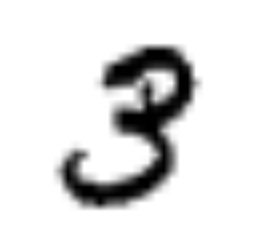

In [4]:
# Plot a random image
sample_number = 5001
plt.imshow(train[sample_number,:-1].reshape(28,28), cmap="gray_r")
plt.axis('off')
print("Image Label: ", train[sample_number,-1])

# 画像を保存

ダウンロードしたデータをローカルストレージに保存しておきます。画像データは平坦にし、28x28ピクセルを長さ784のベクターにして保存します。

![](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

ラベル(ground-truth)は[1-hot][]エンコーディングで保存します。例えば、ラベルが3の時は`0001000000`と表されます。

![](https://www.cntk.ai/jup/cntk103a_onehot.png)

[1-hot]: https://en.wikipedia.org/wiki/One-hot

In [5]:
# Save the data files into a format compatible with CNTK text reader
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)


In [6]:
# Save the train and test files (prefer our default path for the data)
data_dir = os.path.join("..", "Examples", "Image", "DataSets", "MNIST")
if not os.path.exists(data_dir):
    data_dir = os.path.join("data", "MNIST")

print ('Writing train text file...')
savetxt(os.path.join(data_dir, "Train-28x28_cntk_text.txt"), train)

print ('Writing test text file...')
savetxt(os.path.join(data_dir, "Test-28x28_cntk_text.txt"), test)

print('Done')

Writing train text file...
File already exists data/MNIST/Train-28x28_cntk_text.txt
Writing test text file...
File already exists data/MNIST/Test-28x28_cntk_text.txt
Done


**実験のヒント**

まずはCNTK 103 Part Bの分類器を実行してみることをおすすめします。それを基準(ベースライン)として、モデルの性能をさらに上げられるか工夫してみましょう。CNTK readerは様々なデータ処理を自動的に行なっています。データ前処理を変更すると、テスト/学習エラーにどのような影響があるか確認することをおすすめします。

- トレーニングデータをシャッフルしてみてください。ヒント: `permute_indices = np.random.permutation(train.shape[0])`
- データに意図的にノイズを加えることで、汎化誤差 ([generalization error][])が小さくなることがあります。ヒント: `numpy.random` を使って、学習データにノイズを加えてみてください。
- アフィン変換 ([affine transformation][]; 平行移動と回転画像)で、画像を歪めてみると分類性能はどうなるでしょうか。

[generalization error]: https://en.wikipedia.org/wiki/Generalization_error
[affine transformation]: https://en.wikipedia.org/wiki/Affine_transformation